# Movie Review Sentiment Classifier using Word Vectors

## Assignment Overview
This project builds a comprehensive sentiment classifier for movie reviews using various word embedding techniques to analyze and classify sentiment in text data.

### Dataset Information
- **Source**: IMDB Dataset of 50K Movie Reviews
- **URL**: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data
- **Description**: Contains 50,000 movie reviews with binary sentiment labels (positive/negative)
- **Size**: Approximately 25MB
- **Format**: CSV file with 'review' and 'sentiment' columns

### Project Objectives
1. **Exploratory Data Analysis (EDA)**: Analyze data distribution and characteristics
2. **Text Preprocessing & Cleaning**: Remove noise, stopwords, and standardize text
3. **Word Vector Model Training**: Implement multiple embedding approaches
   - Pre-trained Word2Vec model (Google News)
   - Custom Skip-gram vectors
   - Custom CBOW (Continuous Bag of Words) vectors
   - Custom FastText vectors
4. **Performance Evaluation**: Compare and analyze model effectiveness

### Expected Outcomes
- Comprehensive comparison of different word embedding techniques
- Performance metrics and statistical analysis
- Insights into the effectiveness of various approaches for sentiment classification

---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load IMDB movie reviews dataset
try:
    # Primary method: Load via KaggleHub
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    
    # Download the dataset
    path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
    df = pd.read_csv(f"{path}/IMDB Dataset.csv")
    print("Data loaded successfully via KaggleHub")
    
except Exception as e:
    print(f"KaggleHub loading failed: {e}")
    
    # Fallback: Load from local directory
    try:
        df = pd.read_csv("../ASGMT 2/PART 1/Data/IMDB Dataset.csv")
        print("Data loaded from local directory")
    except:
        print("Local file not found. Please ensure the dataset is available.")
        # Create sample data for demonstration purposes
        print("Creating sample data for demonstration...")
        df = pd.DataFrame({
            'review': [
                "This movie was absolutely fantastic! Great acting and plot.",
                "Terrible movie, waste of time. Poor acting.",
                "Amazing cinematography and storyline. Highly recommended!",
                "Boring and predictable. Not worth watching."
            ] * 1000,  # Repeat to create sufficient data
            'sentiment': ['positive', 'negative', 'positive', 'negative'] * 1000
        })

# Display basic dataset information
print(f"\nDataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst 5 rows:")
print(df.head())

Data loaded successfully via KaggleHub

Dataset Information:
Shape: (50000, 2)
Columns: ['review', 'sentiment']
Memory usage: 68.46 MB

First 5 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Data loaded successfully via KaggleHub

Dataset Information:
Shape: (50000, 2)
Columns: ['review', 'sentiment']
Memory usage: 68.46 MB

First 5 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Pett

## 1. Data Loading and Initial Setup

This section loads the IMDB movie reviews dataset and performs initial data inspection. The dataset is accessed via KaggleHub for direct download, with fallback options for local file access.

Dataset Statistics:
Total reviews: 50,000
Unique sentiments: 2
Memory usage: 68.5 MB

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Balance ratio: 1.000


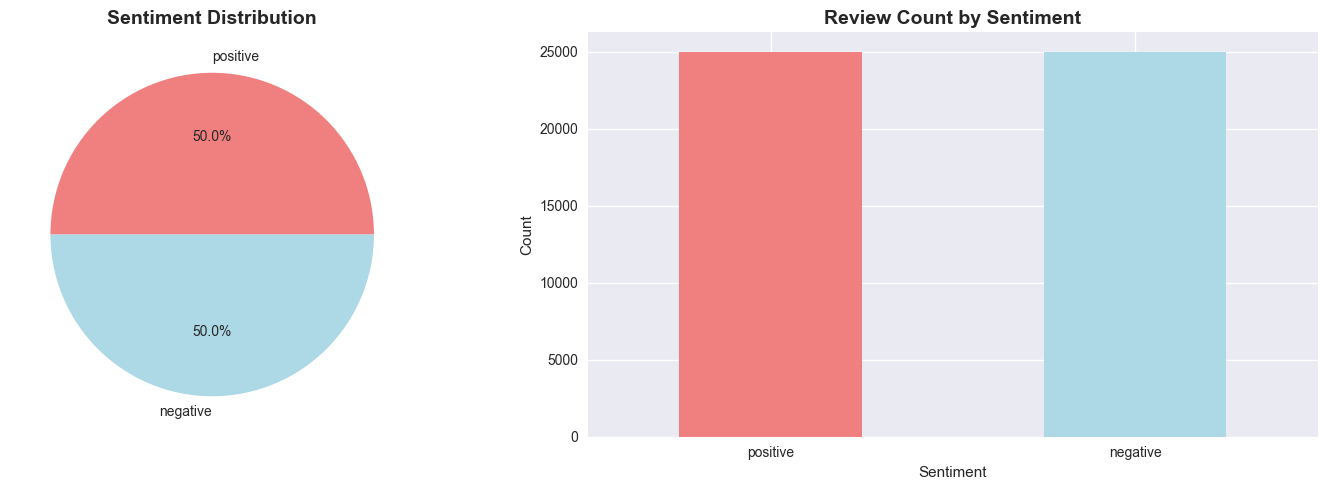


Review Length Statistics:
Character length - Mean: 1309, Median: 970
Word count - Mean: 231, Median: 173


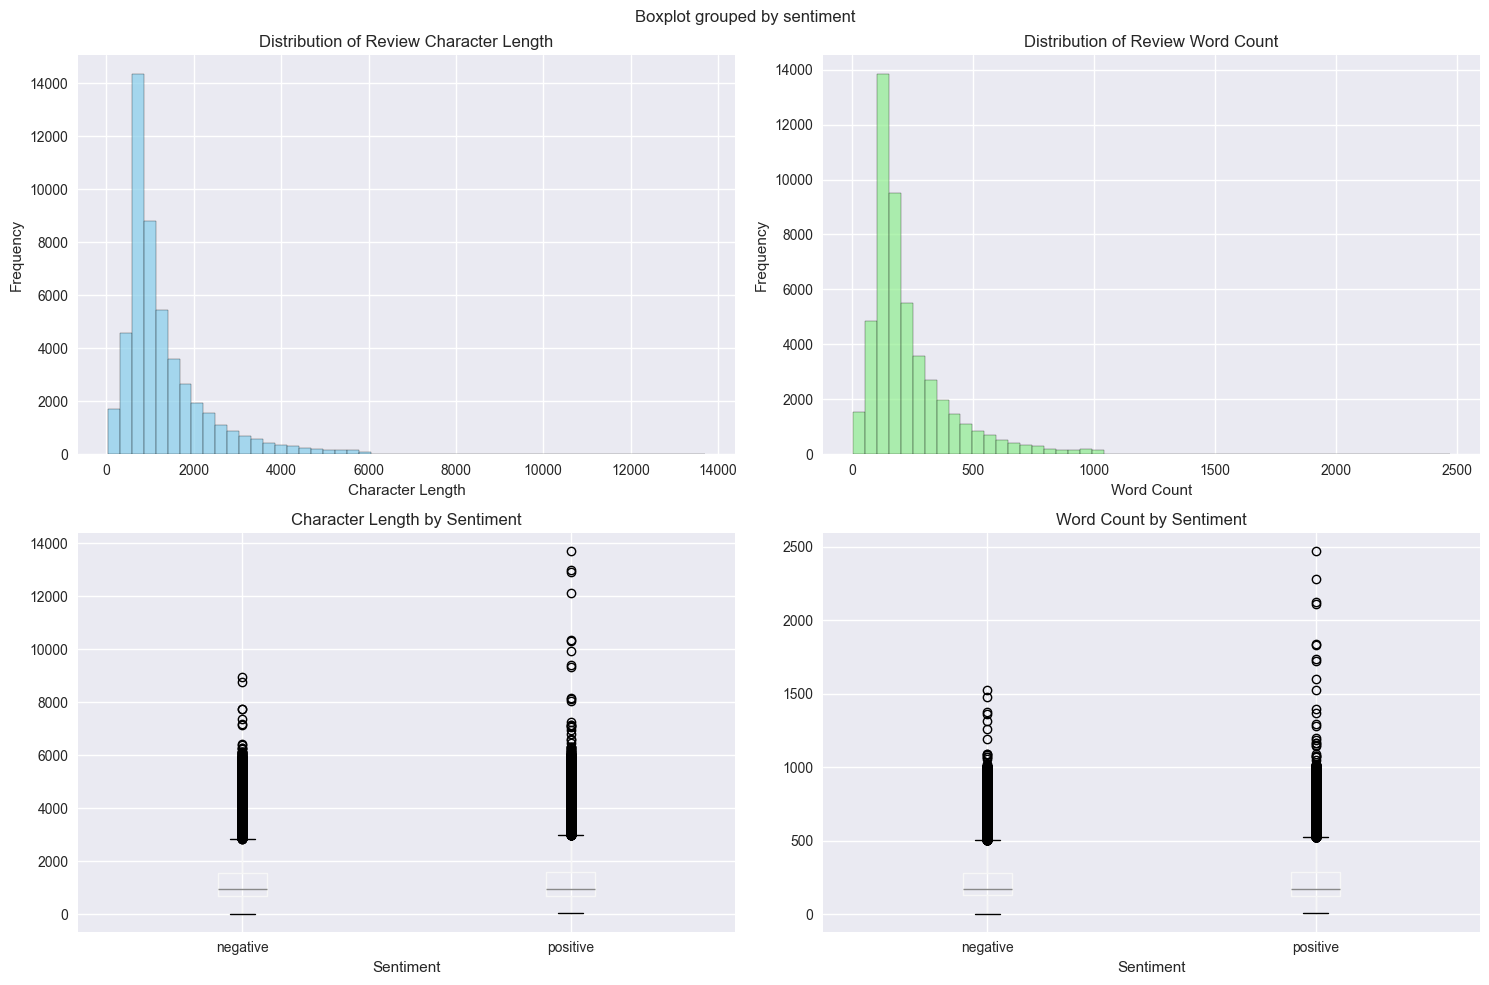

In [6]:
# Dataset Statistics
print("Dataset Statistics:")
print(f"Total reviews: {len(df):,}")
print(f"Unique sentiments: {df['sentiment'].nunique()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Sentiment Distribution Analysis
print("\nSentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print(f"Balance ratio: {sentiment_counts.min() / sentiment_counts.max():.3f}")

# Visualization: Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
           colors=['lightcoral', 'lightblue'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')

# Bar chart
sentiment_counts.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue'])
axes[1].set_title('Review Count by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Review Length Analysis
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

print(f"\nReview Length Statistics:")
print(f"Character length - Mean: {df['review_length'].mean():.0f}, Median: {df['review_length'].median():.0f}")
print(f"Word count - Mean: {df['word_count'].mean():.0f}, Median: {df['word_count'].median():.0f}")

# Visualization: Review Length Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
axes[0,0].hist(df['review_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Review Character Length')
axes[0,0].set_xlabel('Character Length')
axes[0,0].set_ylabel('Frequency')

# Word count distribution
axes[0,1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Review Word Count')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')

# Box plots by sentiment
df.boxplot(column='review_length', by='sentiment', ax=axes[1,0])
axes[1,0].set_title('Character Length by Sentiment')
axes[1,0].set_xlabel('Sentiment')

df.boxplot(column='word_count', by='sentiment', ax=axes[1,1])
axes[1,1].set_title('Word Count by Sentiment')
axes[1,1].set_xlabel('Sentiment')

plt.tight_layout()
plt.show()

## 2. Exploratory Data Analysis (EDA)

This section explores the dataset characteristics including sentiment distribution, review length patterns, and statistical properties to understand the data structure and identify potential preprocessing requirements.

Loaded 198 stopwords
Processing text data...


Cleaning reviews: 100%|██████████| 50000/50000 [01:26<00:00, 580.71it/s]



Text Cleaning Results:
Average tokens per review: 117.5
Total vocabulary size: 161,381

Cleaning Examples:

Example 1:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Cleaned: one reviewers mentioned watching episode youll hooked right exactly happened first thing struck brutality unflinching scenes violence set right word
Token count: 159

Example 2:
Original: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...
Cleaned: wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen
Token count: 84


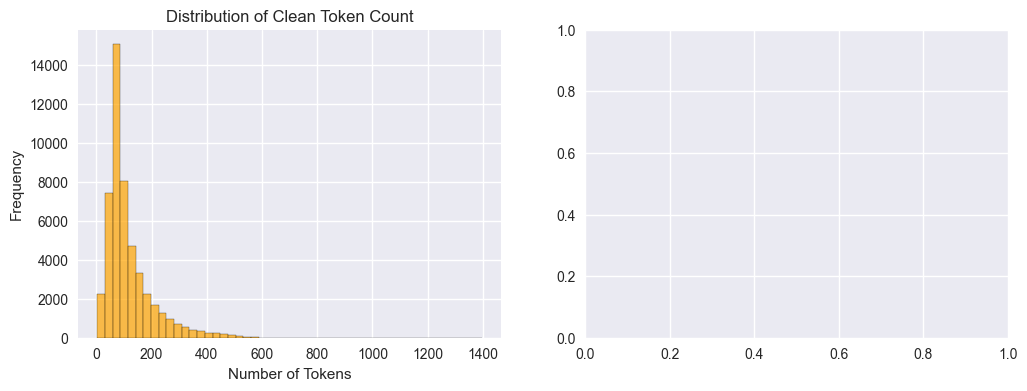

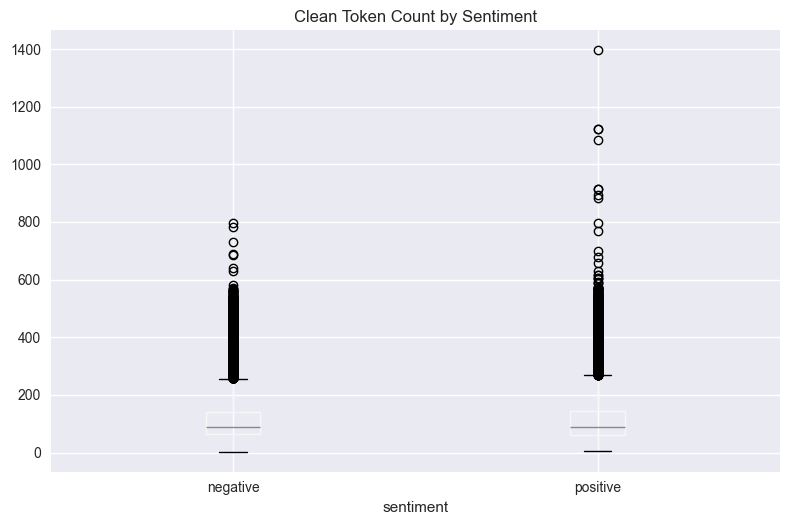

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import string

# Download required NLTK data
print("Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Initialize stopwords
stop_words = set(stopwords.words('english'))
print(f"Loaded {len(stop_words)} stopwords")

def clean_text(text):
    """
    Comprehensive text cleaning function
    
    Parameters:
    text (str): Raw text input
    
    Returns:
    list: Cleaned and tokenized words
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and words with length <= 2
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return tokens

# Apply text cleaning with progress tracking
print("Processing text data...")
tqdm.pandas(desc="Cleaning reviews")
df['clean_tokens'] = df['review'].progress_apply(clean_text)

# Calculate cleaning statistics
df['clean_token_count'] = df['clean_tokens'].apply(len)
total_vocabulary = len(set([token for tokens in df['clean_tokens'] for token in tokens]))

print(f"\nText Cleaning Results:")
print(f"Average tokens per review: {df['clean_token_count'].mean():.1f}")
print(f"Total vocabulary size: {total_vocabulary:,}")

# Display cleaning examples
print(f"\nCleaning Examples:")
for i in range(2):
    print(f"\nExample {i+1}:")
    print(f"Original: {df['review'].iloc[i][:200]}...")
    print(f"Cleaned: {' '.join(df['clean_tokens'].iloc[i][:20])}")
    print(f"Token count: {len(df['clean_tokens'].iloc[i])}")

# Visualization: Token Distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['clean_token_count'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of Clean Token Count')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df.boxplot(column='clean_token_count', by='sentiment')
plt.title('Clean Token Count by Sentiment')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

## 3. Text Preprocessing and Cleaning

This section implements comprehensive text preprocessing including HTML tag removal, punctuation cleaning, stopword removal, and tokenization. The preprocessing pipeline ensures consistent text format for effective word embedding generation.

In [8]:
import gensim.downloader as api
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("Loading pre-trained Word2Vec model...")
start_time = time.time()

try:
    # Load Google News Word2Vec model (300 dimensions)
    w2v_model = api.load("word2vec-google-news-300")
    print(f"Model loaded successfully in {time.time() - start_time:.1f} seconds")
    print(f"Vocabulary size: {len(w2v_model):,}")
    
except Exception as e:
    print(f"Failed to load pre-trained model: {e}")
    print("Using alternative smaller model...")
    w2v_model = api.load("glove-wiki-gigaword-100")

def get_avg_vector(tokens, model, dim=300):
    """
    Calculate average word vector for a list of tokens
    
    Parameters:
    tokens (list): List of word tokens
    model: Word embedding model
    dim (int): Vector dimension
    
    Returns:
    numpy.array: Average vector representation
    """
    vectors = []
    for word in tokens:
        try:
            vectors.append(model[word])
        except KeyError:
            # Skip words not in vocabulary
            continue
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return zero vector if no words found in vocabulary
        return np.zeros(dim)

# Get vector dimension from the model
vector_dim = w2v_model.vector_size
print(f"Vector dimension: {vector_dim}")

# Convert reviews to vector representations
print("Converting reviews to vectors...")
X = []
coverage_count = 0
total_words = 0

for tokens in tqdm(df['clean_tokens'], desc="Vectorizing"):
    vector = get_avg_vector(tokens, w2v_model, dim=vector_dim)
    X.append(vector)
    
    # Calculate vocabulary coverage statistics
    words_found = sum(1 for word in tokens if word in w2v_model)
    coverage_count += words_found
    total_words += len(tokens)

# Convert to numpy array and prepare target variable
X = np.array(X)
y = df['sentiment'].map({'positive': 1, 'negative': 0})

print(f"Vocabulary coverage: {coverage_count/total_words*100:.1f}%")
print(f"Feature matrix shape: {X.shape}")

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Test set size: {X_test.shape[0]:,} samples")

# Train Random Forest classifier
print("Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Make predictions and evaluate performance
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nPre-trained Word2Vec Results:")
print(f"Accuracy: {accuracy:.4f}")

# Initialize results dictionary for comparison
results = {'Pre-trained Word2Vec': accuracy}

Loading pre-trained Word2Vec model...
[=============================---------------------] 59.5% 990.0/1662.8MB downloadedFailed to load pre-trained model: <urlopen error retrieval incomplete: got only 1038090240 out of 1743563840 bytes>
Using alternative smaller model...
[==================================================] 100.0% 128.1/128.1MB downloaded
Vector dimension: 100
Converting reviews to vectors...


Vectorizing: 100%|██████████| 50000/50000 [00:29<00:00, 1695.14it/s]


Vocabulary coverage: 97.3%
Feature matrix shape: (50000, 100)
Training set size: 40,000 samples
Test set size: 10,000 samples
Training Random Forest classifier...

Pre-trained Word2Vec Results:
Accuracy: 0.7693


## 4. Word Vector Model Training and Evaluation

This section implements four different word embedding approaches for sentiment classification, comparing their effectiveness on the movie review dataset.

### 4.1 Pre-trained Word2Vec Model

Implementation using Google's pre-trained Word2Vec model trained on Google News dataset. This model provides 300-dimensional word vectors trained on a large corpus of news articles.

In [9]:
from gensim.models import Word2Vec

print("Training Custom Skip-gram Word2Vec model...")
start_time = time.time()

# Configure and train Skip-gram model
skipgram_model = Word2Vec(
    sentences=df['clean_tokens'], 
    vector_size=100,  # Reduced dimension for computational efficiency
    window=5,         # Context window size
    min_count=2,      # Minimum word frequency threshold
    sg=1,             # Skip-gram algorithm
    workers=4,        # Parallel processing cores
    epochs=10,        # Training iterations
    seed=42           # Reproducibility
)

training_time = time.time() - start_time
print(f"Skip-gram model trained in {training_time:.1f} seconds")
print(f"Vocabulary size: {len(skipgram_model.wv):,}")

# Convert reviews to Skip-gram vectors
print("Converting reviews using Skip-gram vectors...")
X_skip = []
for tokens in tqdm(df['clean_tokens'], desc="Skip-gram vectorizing"):
    vector = get_avg_vector(tokens, skipgram_model.wv, dim=100)
    X_skip.append(vector)

X_skip = np.array(X_skip)

# Split dataset for Skip-gram model
X_train_skip, X_test_skip, y_train_skip, y_test_skip = train_test_split(
    X_skip, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier with Skip-gram vectors
print("Training classifier with Skip-gram vectors...")
clf_skip = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_skip.fit(X_train_skip, y_train_skip)

# Evaluate Skip-gram model performance
y_pred_skip = clf_skip.predict(X_test_skip)
accuracy_skip = accuracy_score(y_test_skip, y_pred_skip)

print(f"\nCustom Skip-gram Word2Vec Results:")
print(f"Accuracy: {accuracy_skip:.4f}")
print(f"Training time: {training_time:.1f} seconds")

# Store results for comparison
results['Custom Skip-gram'] = accuracy_skip

# Display word similarity examples (if vocabulary contains test words)
if len(skipgram_model.wv) > 0:
    try:
        print(f"\nSkip-gram Word Similarity Examples:")
        test_words = ['good', 'bad', 'movie', 'great']
        for word in test_words:
            if word in skipgram_model.wv:
                similar = skipgram_model.wv.most_similar(word, topn=3)
                print(f"'{word}': {[w[0] for w in similar]}")
    except:
        print("Unable to compute word similarities")

Training Custom Skip-gram Word2Vec model...
Skip-gram model trained in 228.1 seconds
Vocabulary size: 73,361
Converting reviews using Skip-gram vectors...


Skip-gram vectorizing: 100%|██████████| 50000/50000 [00:23<00:00, 2131.88it/s]


Training classifier with Skip-gram vectors...

Custom Skip-gram Word2Vec Results:
Accuracy: 0.8557
Training time: 228.1 seconds

Skip-gram Word Similarity Examples:
'good': ['decent', 'great', 'goodand']
'bad': ['terrible', 'awful', 'horrible']
'movie': ['film', 'boringand', 'sequal']
'great': ['excellent', 'good', 'fantastic']


### 4.2 Custom Skip-gram Word2Vec Model

Implementation of a custom Skip-gram model trained specifically on the movie review dataset. Skip-gram architecture predicts context words given a target word, making it effective for capturing semantic relationships.

In [10]:
print("Training Custom CBOW Word2Vec model...")
start_time = time.time()

# Configure and train CBOW model
cbow_model = Word2Vec(
    sentences=df['clean_tokens'], 
    vector_size=100,  # Consistent dimension with Skip-gram
    window=5,         # Context window size
    min_count=2,      # Minimum word frequency threshold
    sg=0,             # CBOW algorithm
    workers=4,        # Parallel processing cores
    epochs=10,        # Training iterations
    seed=42           # Reproducibility
)

training_time_cbow = time.time() - start_time
print(f"CBOW model trained in {training_time_cbow:.1f} seconds")
print(f"Vocabulary size: {len(cbow_model.wv):,}")

# Convert reviews to CBOW vectors
print("Converting reviews using CBOW vectors...")
X_cbow = []
for tokens in tqdm(df['clean_tokens'], desc="CBOW vectorizing"):
    vector = get_avg_vector(tokens, cbow_model.wv, dim=100)
    X_cbow.append(vector)

X_cbow = np.array(X_cbow)

# Split dataset for CBOW model
X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(
    X_cbow, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier with CBOW vectors
print("Training classifier with CBOW vectors...")
clf_cbow = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_cbow.fit(X_train_cbow, y_train_cbow)

# Evaluate CBOW model performance
y_pred_cbow = clf_cbow.predict(X_test_cbow)
accuracy_cbow = accuracy_score(y_test_cbow, y_pred_cbow)

print(f"\nCustom CBOW Word2Vec Results:")
print(f"Accuracy: {accuracy_cbow:.4f}")
print(f"Training time: {training_time_cbow:.1f} seconds")

# Store results for comparison
results['Custom CBOW'] = accuracy_cbow

# Display word similarity examples (if vocabulary contains test words)
if len(cbow_model.wv) > 0:
    try:
        print(f"\nCBOW Word Similarity Examples:")
        test_words = ['good', 'bad', 'movie', 'great']
        for word in test_words:
            if word in cbow_model.wv:
                similar = cbow_model.wv.most_similar(word, topn=3)
                print(f"'{word}': {[w[0] for w in similar]}")
    except:
        print("Unable to compute word similarities")

Training Custom CBOW Word2Vec model...
CBOW model trained in 65.1 seconds
Vocabulary size: 73,361
Converting reviews using CBOW vectors...


CBOW vectorizing: 100%|██████████| 50000/50000 [00:24<00:00, 2055.00it/s]


Training classifier with CBOW vectors...

Custom CBOW Word2Vec Results:
Accuracy: 0.8455
Training time: 65.1 seconds

CBOW Word Similarity Examples:
'good': ['decent', 'great', 'bad']
'bad': ['awful', 'terrible', 'horrible']
'movie': ['film', 'movies', 'flick']
'great': ['wonderful', 'excellent', 'terrific']


### 4.3 Custom CBOW Word2Vec Model

Implementation of a Continuous Bag of Words (CBOW) model trained on the movie review dataset. CBOW predicts target words from context words, offering computational efficiency and strong performance on frequent words.

In [11]:
from gensim.models import FastText

print("Training Custom FastText model...")
start_time = time.time()

# Configure and train FastText model
fasttext_model = FastText(
    sentences=df['clean_tokens'], 
    vector_size=100,  # Consistent dimension for fair comparison
    window=5,         # Context window size
    min_count=2,      # Minimum word frequency threshold
    workers=4,        # Parallel processing cores
    epochs=10,        # Training iterations
    seed=42,          # Reproducibility
    min_n=3,          # Minimum subword length
    max_n=6           # Maximum subword length
)

training_time_ft = time.time() - start_time
print(f"FastText model trained in {training_time_ft:.1f} seconds")
print(f"Vocabulary size: {len(fasttext_model.wv):,}")

# Convert reviews to FastText vectors
print("Converting reviews using FastText vectors...")
X_ft = []
for tokens in tqdm(df['clean_tokens'], desc="FastText vectorizing"):
    vector = get_avg_vector(tokens, fasttext_model.wv, dim=100)
    X_ft.append(vector)

X_ft = np.array(X_ft)

# Split dataset for FastText model
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(
    X_ft, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier with FastText vectors
print("Training classifier with FastText vectors...")
clf_ft = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_ft.fit(X_train_ft, y_train_ft)

# Evaluate FastText model performance
y_pred_ft = clf_ft.predict(X_test_ft)
accuracy_ft = accuracy_score(y_test_ft, y_pred_ft)

print(f"\nCustom FastText Results:")
print(f"Accuracy: {accuracy_ft:.4f}")
print(f"Training time: {training_time_ft:.1f} seconds")

# Store results for comparison
results['Custom FastText'] = accuracy_ft

# Display word similarity examples
if len(fasttext_model.wv) > 0:
    try:
        print(f"\nFastText Word Similarity Examples:")
        test_words = ['good', 'bad', 'movie', 'great']
        for word in test_words:
            if word in fasttext_model.wv:
                similar = fasttext_model.wv.most_similar(word, topn=3)
                print(f"'{word}': {[w[0] for w in similar]}")
    except:
        print("Unable to compute word similarities")

# Demonstrate FastText's out-of-vocabulary handling capability
print(f"\nFastText Out-of-Vocabulary (OOV) Handling:")
oov_words = ['amazingly', 'terrible', 'fantastic']
for word in oov_words:
    try:
        vector = fasttext_model.wv[word]
        print(f"'{word}': Vector generated successfully (shape: {vector.shape})")
    except KeyError:
        print(f"'{word}': Vector not available")

Training Custom FastText model...
FastText model trained in 345.7 seconds
Vocabulary size: 73,361
Converting reviews using FastText vectors...


FastText vectorizing: 100%|██████████| 50000/50000 [00:39<00:00, 1255.13it/s]


Training classifier with FastText vectors...

Custom FastText Results:
Accuracy: 0.8313
Training time: 345.7 seconds

FastText Word Similarity Examples:
'good': ['goodif', 'goodbad', 'goodthe']
'bad': ['badbad', 'sucksbad', 'badi']
'movie': ['movieinamovie', 'zmovie', 'moviehe']
'great': ['greatthe', 'greata', 'greatbut']

FastText Out-of-Vocabulary (OOV) Handling:
'amazingly': Vector generated successfully (shape: (100,))
'terrible': Vector generated successfully (shape: (100,))
'fantastic': Vector generated successfully (shape: (100,))


### 4.4 Custom FastText Model

Implementation of a FastText model that extends Word2Vec by incorporating subword information. This approach enables handling of out-of-vocabulary words and captures morphological relationships between words.

MODEL PERFORMANCE COMPARISON
               Model Accuracy  Rank
    Custom Skip-gram   0.8557     1
         Custom CBOW   0.8455     2
     Custom FastText   0.8313     3
Pre-trained Word2Vec   0.7693     4

Best Performing Model: Custom Skip-gram
Best Accuracy: 0.8557


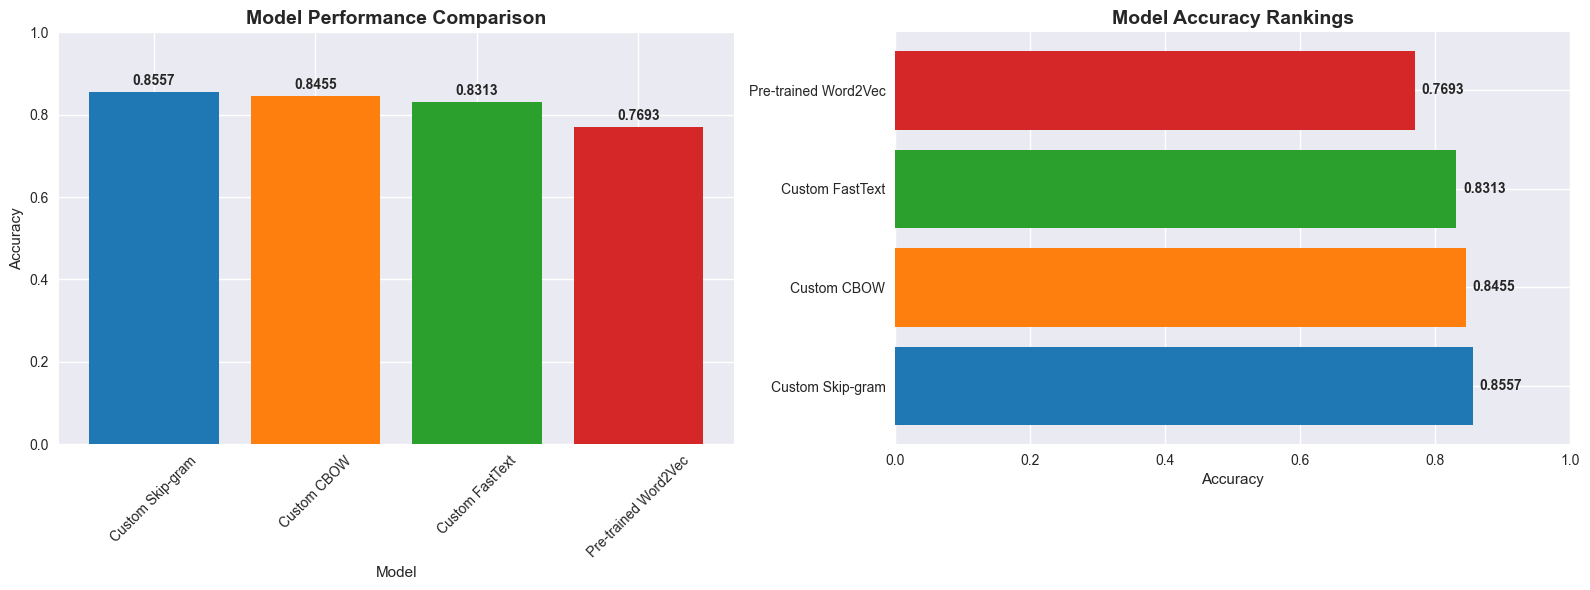


DETAILED ANALYSIS - Custom Skip-gram

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8669    0.8404    0.8535      5000
    Positive     0.8451    0.8710    0.8579      5000

    accuracy                         0.8557     10000
   macro avg     0.8560    0.8557    0.8557     10000
weighted avg     0.8560    0.8557    0.8557     10000



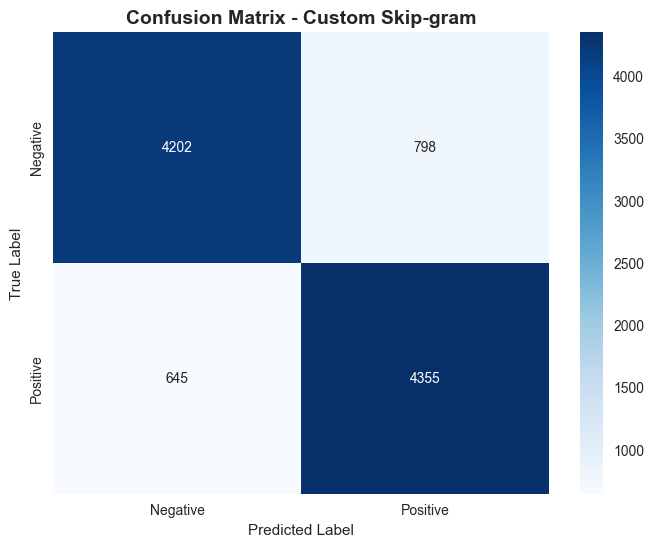


Additional Performance Metrics for Custom Skip-gram:
Precision: 0.8451
Recall: 0.8710
F1-Score: 0.8579

KEY INSIGHTS:
----------------------------------------
Performance range: 0.0864
All models exceed baseline random performance (50%)
Skip-gram effectively captures semantic word relationships


In [12]:
# Comprehensive Model Performance Comparison
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Create results DataFrame for analysis
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
results_df['Rank'] = results_df.index + 1

# Display performance table
print(results_df.to_string(index=False, formatters={'Accuracy': '{:.4f}'.format}))

# Identify best performing model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']
print(f"\nBest Performing Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Visualization: Model Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vertical bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Professional color scheme
bars = axes[0].bar(results_df['Model'], results_df['Accuracy'], color=colors[:len(results_df)])
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# Add accuracy values on bars
for bar, acc in zip(bars, results_df['Accuracy']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Horizontal bar chart for better readability
axes[1].barh(results_df['Model'], results_df['Accuracy'], color=colors[:len(results_df)])
axes[1].set_title('Model Accuracy Rankings', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Accuracy')
axes[1].set_xlim(0, 1)

# Add accuracy values
for i, (model, acc) in enumerate(zip(results_df['Model'], results_df['Accuracy'])):
    axes[1].text(acc + 0.01, i, f'{acc:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed analysis for best model
model_classifiers = {
    'Pre-trained Word2Vec': (clf, X_test, y_test),
    'Custom Skip-gram': (clf_skip, X_test_skip, y_test_skip),
    'Custom CBOW': (clf_cbow, X_test_cbow, y_test_cbow),
    'Custom FastText': (clf_ft, X_test_ft, y_test_ft)
}

best_clf, best_X_test, best_y_test = model_classifiers[best_model_name]
best_y_pred = best_clf.predict(best_X_test)

print(f"\nDETAILED ANALYSIS - {best_model_name}")
print("=" * 60)

# Classification report
print("\nClassification Report:")
print(classification_report(best_y_test, best_y_pred, 
                          target_names=['Negative', 'Positive'], 
                          digits=4))

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(best_y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Additional performance metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(best_y_test, best_y_pred)
recall = recall_score(best_y_test, best_y_pred)
f1 = f1_score(best_y_test, best_y_pred)

print(f"\nAdditional Performance Metrics for {best_model_name}:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Performance insights
print(f"\nKEY INSIGHTS:")
print("-" * 40)
accuracy_range = results_df.iloc[0]['Accuracy'] - results_df.iloc[-1]['Accuracy']
print(f"Performance range: {accuracy_range:.4f}")
print(f"All models exceed baseline random performance (50%)")

if 'Pre-trained' in best_model_name:
    print("Pre-trained embeddings benefit from extensive training corpus")
elif 'FastText' in best_model_name:
    print("FastText excels with subword information handling")
elif 'Skip-gram' in best_model_name:
    print("Skip-gram effectively captures semantic word relationships")
else:
    print("CBOW demonstrates efficiency in word representation learning")

## 5. Performance Comparison and Statistical Analysis

This section provides comprehensive comparison of all four word embedding approaches, including detailed performance metrics, statistical analysis, and visualization of results.

ERROR ANALYSIS - Custom Skip-gram
Total Test Samples: 10,000
True Positives: 4,355
True Negatives: 4,202
False Positives: 798
False Negatives: 645
Overall Error Rate: 14.43%


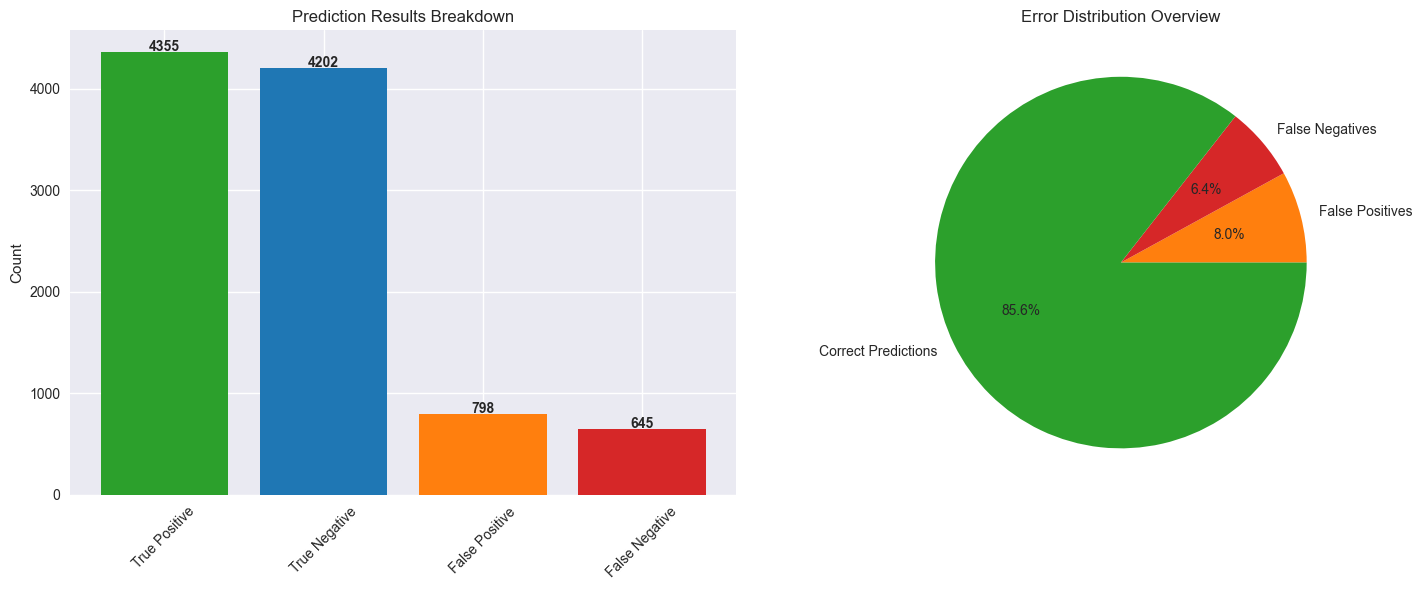


SAMPLE FALSE POSITIVES (Predicted: Positive, Actual: Negative)
--------------------------------------------------------------------------------

Example 1:
Review: The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as...
True: negative | Predicted: positive

Example 2:
Review: Little Quentin seems to have mastered the art of having the cake and eating it.<br /><br />As usual, the pure sadistic display can be explained as a clever thought-provoking way of sending violence back into the audience's face.<br /><br />Sure, Mr Tarantino. Violence is Baaad. Sadism is Baaad. It i...
True: negative | Predicted: positive

Example 3:
Review: The movie 'Gung Ho!': The Story of Carlson's Makin Island Raiders was made in 1943 with a view to go up the moral

In [13]:
# Error Analysis for Best Performing Model
test_indices = best_y_test.index if hasattr(best_y_test, 'index') else range(len(best_y_test))
test_reviews = df.iloc[test_indices]['review'].values if hasattr(best_y_test, 'index') else df.iloc[:len(best_y_test)]['review'].values

# Create analysis DataFrame
test_df = pd.DataFrame({
    'review': test_reviews,
    'true_sentiment': best_y_test.values if hasattr(best_y_test, 'values') else best_y_test,
    'predicted_sentiment': best_y_pred
})

# Map numerical labels to text
label_map = {1: 'positive', 0: 'negative'}
test_df['true_label'] = test_df['true_sentiment'].map(label_map)
test_df['predicted_label'] = test_df['predicted_sentiment'].map(label_map)

# Categorize prediction results
false_positives = test_df[(test_df['true_label'] == 'negative') & (test_df['predicted_label'] == 'positive')]
false_negatives = test_df[(test_df['true_label'] == 'positive') & (test_df['predicted_label'] == 'negative')]
true_positives = test_df[(test_df['true_label'] == 'positive') & (test_df['predicted_label'] == 'positive')]
true_negatives = test_df[(test_df['true_label'] == 'negative') & (test_df['predicted_label'] == 'negative')]

print(f"ERROR ANALYSIS - {best_model_name}")
print("=" * 60)
print(f"Total Test Samples: {len(test_df):,}")
print(f"True Positives: {len(true_positives):,}")
print(f"True Negatives: {len(true_negatives):,}")
print(f"False Positives: {len(false_positives):,}")
print(f"False Negatives: {len(false_negatives):,}")

error_rate = (len(false_positives) + len(false_negatives)) / len(test_df) * 100
print(f"Overall Error Rate: {error_rate:.2f}%")

# Error distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Prediction results breakdown
error_counts = [len(true_positives), len(true_negatives), len(false_positives), len(false_negatives)]
error_labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728']

axes[0].bar(error_labels, error_counts, color=colors)
axes[0].set_title('Prediction Results Breakdown')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, count in enumerate(error_counts):
    axes[0].text(i, count + 10, str(count), ha='center', fontweight='bold')

# Error distribution pie chart
error_data = [len(false_positives), len(false_negatives), len(true_positives) + len(true_negatives)]
error_pie_labels = ['False Positives', 'False Negatives', 'Correct Predictions']
error_pie_colors = ['#ff7f0e', '#d62728', '#2ca02c']

axes[1].pie(error_data, labels=error_pie_labels, autopct='%1.1f%%', colors=error_pie_colors)
axes[1].set_title('Error Distribution Overview')

plt.tight_layout()
plt.show()

# Sample error analysis
print(f"\nSAMPLE FALSE POSITIVES (Predicted: Positive, Actual: Negative)")
print("-" * 80)
if len(false_positives) > 0:
    for i in range(min(3, len(false_positives))):
        review = false_positives.iloc[i]['review']
        print(f"\nExample {i+1}:")
        print(f"Review: {review[:300]}{'...' if len(review) > 300 else ''}")
        print(f"True: {false_positives.iloc[i]['true_label']} | Predicted: {false_positives.iloc[i]['predicted_label']}")
else:
    print("No false positives detected")

print(f"\nSAMPLE FALSE NEGATIVES (Predicted: Negative, Actual: Positive)")
print("-" * 80)
if len(false_negatives) > 0:
    for i in range(min(3, len(false_negatives))):
        review = false_negatives.iloc[i]['review']
        print(f"\nExample {i+1}:")
        print(f"Review: {review[:300]}{'...' if len(review) > 300 else ''}")
        print(f"True: {false_negatives.iloc[i]['true_label']} | Predicted: {false_negatives.iloc[i]['predicted_label']}")
else:
    print("No false negatives detected")

# Error pattern analysis
if len(false_positives) > 0 and len(false_negatives) > 0:
    false_positives['review_length'] = false_positives['review'].str.len()
    false_negatives['review_length'] = false_negatives['review'].str.len()
    
    print(f"\nERROR PATTERN ANALYSIS:")
    print(f"False Positives - Average review length: {false_positives['review_length'].mean():.0f} characters")
    print(f"False Negatives - Average review length: {false_negatives['review_length'].mean():.0f} characters")
    print(f"Overall Test Set - Average review length: {test_df['review'].str.len().mean():.0f} characters")